## Stepik ML contest
# Project "Predicting user actions in an online educational course"

This notebook is based on the Introduction to Data Science and Machine Learning course.
https://stepik.org/lesson/222124/

The goal of the project is to build a model based on the first actions of а user, which will be able to predict whether a user will complete or quit the course [Введение в анализ данных в R](https://stepik.org/course/129/syllabus).

### Data Description:

[events_train.csv](https://stepik.org/media/attachments/course/4852/event_data_train.zip) - data about student actions on each step

**step_id** - step's id

**user_id** - anonymized user id

**timestamp** - time of the event in unix date format

**action** - event, , possible values: 
* discovered - user opened the step,
* viewed - the step was viewed,
* started_attempt - start time of attempt to solve the practice step
* passed - successful practical step solution

[submissions_train.csv](https://stepik.org/media/attachments/course/4852/submissions_data_train.zip) - data about time and statuses of practice steps submission

**step_id** - step's id

**timestamp** - time of submission the solution in unix date format

**submission_status** - status of the submission

**user_id** - anonymized user id

In [133]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

ERROR! Session/line number was not unique in database. History logging moved to new session 341


Set figure size by passing dictionary to rc parameter with key 'figure.figsize' in seaborn set method

In [2]:
sns.set(rc={'figure.figsize':(9,6)})

We load a dataset with data about student actions on each step into DataFrame using Pandas library.

In [3]:
events_data= pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')

In [4]:
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


# Data visualization and pre-processing

Let's do some basic data exploration and see what types of data are in the columns.

In [5]:
events_data.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

Let's see what action types are in the action column.

In [6]:
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Change the time format to make it more readable with adding the date column

In [7]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit = 's')

In [8]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


Let's see the data formats

In [9]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

Let's see the date when the course was started and what is the last day in the dataset.

In [10]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [11]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

Add a column with the day of the action

In [12]:
events_data['day'] = events_data.date.dt.date

In [13]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Let's build a graph of students' activity for all time and see how many unique students there were for each day

In [14]:
events_data.groupby('day') \
    .user_id.nunique().head()

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
Name: user_id, dtype: int64

<AxesSubplot:xlabel='day'>

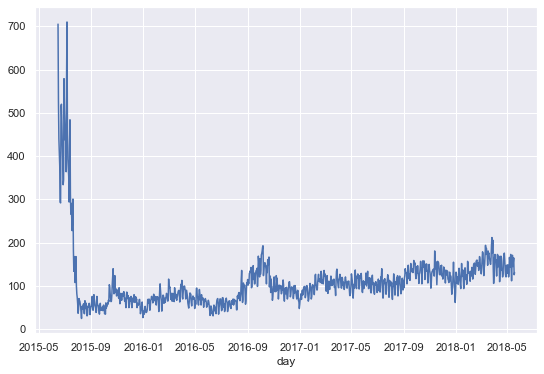

In [15]:
events_data.groupby('day') \
    .user_id.nunique().plot()

From the initial studies of the data, it can be said that, in general, the data are valid and can be used for further research.

Determine how many students passed how many tasks.
Only those students who have passed at least one task are taken into account here.

In [16]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index = False) \
    .agg({'step_id': 'count'}) \
    .rename(columns = {'step_id': 'passed_steps'}).head()

,user_id,passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


Graph a hist

<AxesSubplot:>

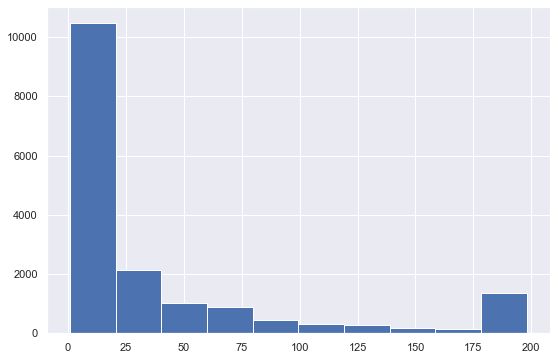

In [17]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index = False) \
    .agg({'step_id': 'count'}) \
    .rename(columns = {'step_id': 'passed_steps'}).passed_steps.hist()

In [18]:
events_data[events_data.action == 'passed'] \
    .groupby('user_id', as_index = False) \
    .agg({'step_id': 'count'}) \
    .rename(columns = {'step_id': 'passed_steps'}).passed_steps.min()

1

Count all students, who were on course. 

In [19]:
events_data.pivot_table(index = 'user_id',
                        columns = 'action', 
                        values = 'step_id', 
                        aggfunc = 'count',
                       fill_value=0).reset_index()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1
...,...,...,...,...,...
19229,26790,8,8,1,9
19230,26793,1,0,1,1
19231,26794,69,69,34,180
19232,26797,10,10,2,13


<AxesSubplot:>

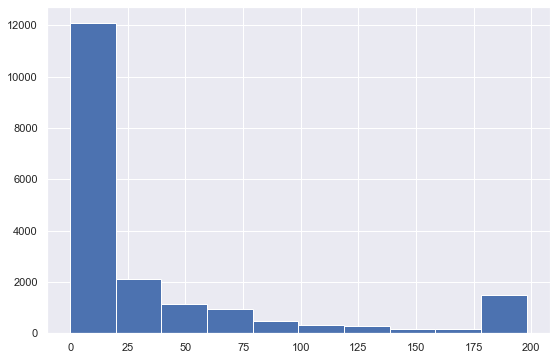

In [20]:
events_data.pivot_table(index = 'user_id',
                        columns = 'action', 
                        values = 'step_id', 
                        aggfunc = 'count',
                       fill_value=0).reset_index().discovered.hist()

Load Data about time and statuses of practice steps submission From CSV File in zip

In [47]:
submissions_data= pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [48]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


Add a column with date and day of the submission

In [49]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [50]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Let's count how many each student made correct and incorrect submissions and save it into users_scores dataframe.

In [51]:
users_scores = submissions_data.pivot_table(index='user_id', 
                                            columns='submission_status', 
                                            values='step_id', 
                                            aggfunc='count',
                                            fill_value=0).reset_index()

In [52]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [53]:
users_scores.sort_values(by='correct', ascending=False).head(10)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
515,1218,130,71
5508,14699,121,33
8895,24022,121,118
10,30,119,79
8410,22713,117,110


Calculate the intervals between unique days when the student took the course

Remove duplicate data about days and user_id

In [54]:
events_data[['user_id', 'day', 'timestamp' ]].drop_duplicates(subset = ['user_id', 'day']).head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


For each student, we will collect in a list all the timestamps when he was online

In [55]:
user_online_data = events_data[['user_id', 'day', 'timestamp' ]].drop_duplicates(subset = ['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list)

In [56]:
user_online_data.head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

Let's calculate the difference between the two nearest timestamps in the lists

In [57]:
user_online_data.apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [58]:
gap_data = user_online_data.apply(np.diff).values

In [59]:
gap_data

array([array([], dtype=int32), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int32)], dtype=object)

Concatenate all arrays into one array

In [60]:
np.concatenate(gap_data, axis = 0)

array([4843602, 6899249,  182484, ...,   98252,   57019, 1567990])

Save the data as a pandas series

In [61]:
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))

In [62]:
gap_data

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int32

Convert into days

In [63]:
gap_data = gap_data / (24*60*60)

In [64]:
gap_data

0         56.060208
1         79.852419
2          2.112083
3          1.084606
4         32.047106
            ...    
97867    166.056586
97868      5.845613
97869      1.137176
97870      0.659942
97871     18.148032
Length: 97872, dtype: float64

Graph histogram where gap time is less than 200 days

<AxesSubplot:>

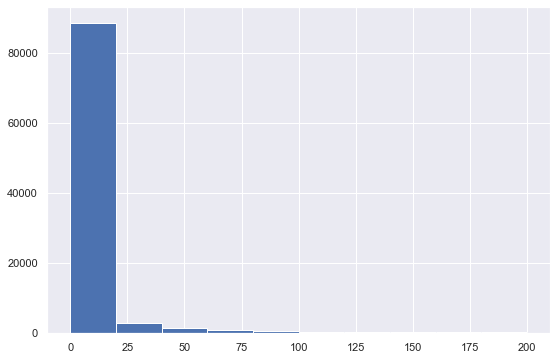

In [66]:
gap_data[gap_data < 200].hist()

Let's calculate the 95 quantile

In [67]:
gap_data.quantile(0.95)

59.760440972222156

In [68]:
gap_data.quantile(0.9)

18.325995370370403

**So only 10% of users return tothe course after a breake of 18.3 days and only 5% of users return to the course after a breake of 59.7 days**

**Thus, let's take 30 days to determine that a student has dropped out of a course.**

Let's determine students who have not finished the course and have a study break more than 30 days

Let's see the last day in dataset

In [72]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [79]:
now = events_data.timestamp.max()

Convert 30 days to seconds

In [81]:
drop_out_threshold = 30 * 24 * 60 * 60

In [82]:
now

1526772811

In [83]:
drop_out_threshold

2592000

For every student count the last day  on the course 

In [85]:
users_data = events_data.groupby('user_id', as_index=False) \
.agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [86]:
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


Add column where we determine did students drop out the course or not

Now count was the last break more than 30 day or not

In [87]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [88]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [90]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [91]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [92]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


Change NaN values to zero

In [93]:
users_data = users_data.fillna(0)

In [96]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


Join data about other actions to the last dataframe

In [100]:
users_events_data = events_data.pivot_table(index='user_id', 
                                            columns='action', 
                                            values='step_id', 
                                            aggfunc='count',
                                            fill_value=0).reset_index()

In [101]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [102]:
users_data = users_data.merge(users_events_data, how='outer')

In [103]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Count unique days on course for every student

In [105]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [106]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


Join this data to the dataframe

In [107]:
users_data = users_data.merge(users_days, how='outer')

In [108]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Check that we didn't lose any student

In [110]:
users_data.user_id.nunique()

19234

In [112]:
events_data.user_id.nunique()

19234

We will assume that the student has completed the course if he scored more than 170 points

Add column with data about passing of the course

In [113]:
users_data['passed_corse'] = users_data.passed > 170

In [114]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Count how many students passed the course and how many students drop out the course

In [116]:
users_data.groupby('passed_corse').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_corse,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


Let's build a histogram with the number of days it took to complete the course

<AxesSubplot:>

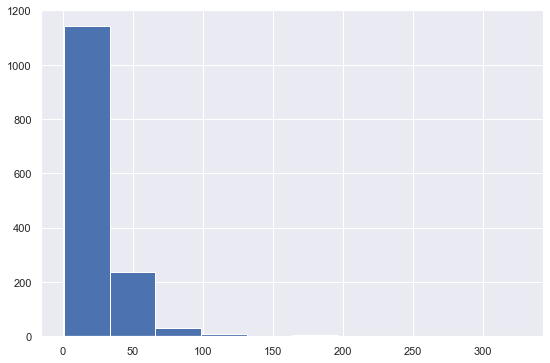

In [118]:
users_data[users_data.passed_corse].day.hist()

Count median

In [120]:
users_data[users_data.passed_corse].day.median()

20.0

Choose first three days from activity of students on course

First, find day, when student start to learn on course

In [123]:
user_min_time = events_data.groupby('user_id', as_index=False) \
.agg({'timestamp': 'min'}) \
.rename({'timestamp': 'min_timestamp'}, axis=1)

In [127]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [128]:
users_data = users_data.merge(user_min_time, how='outer')

In [130]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [126]:
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [ ]:
events_data_train = pd.DataFrame()

In order to select only three days after the start of study, we will create a column that will be a combination of user_id and timestamp

In [134]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [136]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895


Convert three days in seconds

In [138]:
learning_time_threshold = 3 * 24 * 60 * 60

Create a seria that will be a combination of user_id and min_timestamp + learning_time_threshold

In [140]:
user_learning_time_threshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_threshold).map(str)

In [141]:
user_learning_time_threshold.head()

0    1_1473086664
1    2_1514642564
2    3_1434617676
3    5_1466416009
4    7_1521893860
dtype: object

In [142]:
user_min_time['user_learning_time_threshold'] = user_learning_time_threshold

In [143]:
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how='outer')

In [144]:
events_data.shape

(3480703, 8)

In [145]:
events_data.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Now choose rows, where user_time is less than user_learning_time_threshold

In [146]:
events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_threshold]

In [147]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


Check, that in dataframe we leave only 3 twenty-four hours

In [229]:
events_data_train.groupby('user_id').day.nunique().max()

4

Number 4 is suitable if the student starts studying in the evening

Let's do same thing for the submissions_data

In [232]:
submissions_data['user_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)

In [233]:
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_threshold']], how = 'outer')

In [235]:
submissions_data_train = submissions_data[submissions_data.user_time <= submissions_data.user_learning_time_threshold]

In [236]:
submissions_data_train.groupby('user_id').day.nunique().max()

4

Let's do X dataframe to trane a model

Add information about number of unique days, which a student was on the course to the X dataframe 

In [297]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index()\
    .rename(columns = {'day': 'days'})

Add information about number of unique submitted steps to the X dataframe 

step_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index()\
    .rename(columns={'step_id': 'step_tried'})

In [298]:
X = X.merge(step_tried, on = 'user_id', how = 'outer')

Add information about number of correct and wrong answers to the X dataframe

In [299]:
X = X.merge(submissions_data_train.pivot_table(index='user_id', 
                                            columns='submission_status', 
                                            values='step_id', 
                                            aggfunc='count',
                                            fill_value=0).reset_index())

Add column with correct ratio

In [300]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

Add information about viewing of steps from events_data_train dataframe

In [301]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_threshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [302]:
X = X.merge(events_data_train.pivot_table(index='user_id', 
                                            columns='action', 
                                            values='step_id', 
                                            aggfunc='count',
                                            fill_value=0).reset_index()[['user_id', 'viewed']], how = 'outer')

Fill NaN with zeros

In [303]:
X = X.fillna(0)

Add information about passing course from users_data

In [304]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corse,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [305]:
X = X.merge(users_data[['user_id', 'passed_corse', 'is_gone_user']], on='user_id', how = 'outer')

Remove from the data users who are not yet known whether they will complete the course or not

In [306]:
X = X[~((X.is_gone_user == False) & (X.passed_corse ==False))]

In [307]:
X.head()

,user_id,days,step_tried,correct,wrong,correct_ratio,viewed,passed_corse,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [308]:
X.groupby(['passed_corse', 'is_gone_user']).user_id.count()

passed_corse  is_gone_user
False         True            16560
True          False             141
              True             1284
Name: user_id, dtype: int64

Transfer the information about the passage of the course to y

In [309]:
y = X.passed_corse.map(int)

In [310]:
y.head()

0    0
1    0
2    0
3    0
4    1
Name: passed_corse, dtype: int64

Drop information about passege of th course in X

In [311]:
X = X.drop(['passed_corse', 'is_gone_user'], axis = 1)

In [312]:
X.head()

,user_id,days,step_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


To train a model, user_id is redundent information, so we will transfer it to the index

In [313]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis = 1)

In [314]:
X.head()

,days,step_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132
